# ニューラルネット
## 第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．



####https://nlp100.github.io/ja/ch08.html

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iamtatsuki05/NLP_100/blob/fix_all_merge/NLP_100_8.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 単語ベクトルの和による特徴量
## 問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xiの特徴ベクトルxiを並べた行列Xと，正解ラベルを並べた行列（ベクトル）Yを作成したい．

X=⎛⎝⎜⎜⎜⎜x1x2…xn⎞⎠⎟⎟⎟⎟∈ℝn×d,Y=⎛⎝⎜⎜⎜⎜y1y2…yn⎞⎠⎟⎟⎟⎟∈ℕn
ここで，nは学習データの事例数であり，xi∈ℝdとyi∈ℕはそれぞれ，i∈{1,…,n}番目の事例の特徴量ベクトルと正解ラベルを表す． なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．ℕ<4で4未満の自然数（0を含む）を表すことにすれば，任意の事例の正解ラベルyiはyi∈ℕ<4で表現できる． 以降では，ラベルの種類数をLで表す（今回の分類タスクではL=4である）．

i番目の事例の特徴ベクトルxiは，次式で求める．

xi=1Ti∑t=1Tiemb(wi,t)
ここで，i番目の事例はTi個の（記事見出しの）単語列(wi,1,wi,2,…,wi,Ti)から構成され，emb(w)∈ℝdは単語wに対応する単語ベクトル（次元数はd）である．すなわち，i番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものがxiである．今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．300次元の単語ベクトルを用いたので，d=300である．

i番目の事例のラベルyiは，次のように定義する．

yi=⎧⎩⎨⎪⎪0123(記事xiが「ビジネス」カテゴリの場合)(記事xiが「科学技術」カテゴリの場合)(記事xiが「エンターテイメント」カテゴリの場合)(記事xiが「健康」カテゴリの場合)
なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．

学習データの特徴量行列: Xtrain∈ℝNt×d
学習データのラベルベクトル: Ytrain∈ℕNt
検証データの特徴量行列: Xvalid∈ℝNv×d
検証データのラベルベクトル: Yvalid∈ℕNv
評価データの特徴量行列: Xtest∈ℝNe×d
評価データのラベルベクトル: Ytest∈ℕNe
なお，Nt,Nv,Neはそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．

In [2]:
# 学習データの特徴量行列: Xtrain
# 学習データのラベルベクトル: Ytrain
# 検証データの特徴量行列: Xvalid
# 検証データのラベルベクトル: Yvalid
# 評価データの特徴量行列: Xtest
# 評価データのラベルベクトル: Ytest
# Nt,Nv,Ne はそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数．

# 問題50のデータをもう一度作成します。
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip
f = open('readme.txt', 'r')
data = f.read()
print(data)

--2022-04-04 01:12:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  11.5MB/s    in 2.4s    

2022-04-04 01:12:30 (11.5 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   
SUMMARY: Dataset of references (urls) to news web pages

DESCRIPTION: Dataset of references to news web pages collected fr

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/newsCorpora.csv' , header=None , sep='\t' , names=['ID' , 'TITLE' , 'URL' , 'PUBLISHER' , 'CATEGORY' , 'STORY' , 'HOSTNAME' , 'TIMESTAMP'])
df = df.loc[df['PUBLISHER'].isin(['Reuters' , 'Huffington Post' , 'Businessweek' , 'Contactmusic.com' , 'Daily Mail']) , ['TITLE' , 'CATEGORY']]

train , other = train_test_split(df , test_size=0.2, shuffle=True, random_state=42 , stratify=df['CATEGORY'])
valid , test = train_test_split(other , test_size=0.5, shuffle=True, random_state=42 , stratify=other['CATEGORY'])

In [4]:
# ダウンロード制限がかかっているのでprthを指定する
# #参考https://qiita.com/jun40vn/items/0f9bd5353197d3f14f3e
# ! pip install --upgrade gdown
# import gdown
# gdown.download('https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download', './GoogleNews-vectors-negative300.bin.gz', quiet=False)
# from gensim.models import KeyedVectors
# model_kv = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz' , binary=True)

In [5]:
# 直接pathを指定する場合
from gensim.models import KeyedVectors
model_kv = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Tutorial/GoogleNews-vectors-negative300.bin.gz' , binary=True)

In [6]:
# 特徴ベクトル化
import torch
import string
import numpy as np

# 6章と同様の処理
def extract(text):
     # 記号変換
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    words = text.translate(table).split()
    # テンソル化
    vectors = [model_kv[word] for word in words if word in model_kv]

    return torch.tensor(sum(vectors) / len(vectors))

In [7]:
X_train = torch.stack([extract(txt) for txt in train['TITLE']])
X_valid = torch.stack([extract(txt) for txt in valid['TITLE']])
X_test = torch.stack([extract(txt) for txt in test['TITLE']])
X_train

tensor([[ 0.0085,  0.0628,  0.0180,  ..., -0.1601,  0.0352,  0.1221],
        [-0.0952,  0.0496,  0.0650,  ...,  0.0259, -0.0036,  0.1435],
        [ 0.0583,  0.0295, -0.0386,  ...,  0.0912,  0.1007, -0.1357],
        ...,
        [ 0.0287,  0.0165, -0.0757,  ..., -0.0712,  0.0378, -0.0391],
        [-0.0738, -0.0352, -0.0405,  ...,  0.0280,  0.0646,  0.0919],
        [ 0.0394,  0.0317,  0.0094,  ...,  0.0160,  0.0709,  0.0104]])

In [8]:
# ラベル
label_map = {'b' : 0 , 't' : 1 , 'e' : 2 , 'm' : 3}
y_train = torch.LongTensor(train['CATEGORY'].map(lambda x: label_map[x]).values)
y_valid = torch.LongTensor(valid['CATEGORY'].map(lambda x: label_map[x]).values)
y_test = torch.LongTensor(test['CATEGORY'].map(lambda x: label_map[x]).values)
y_train

tensor([2, 0, 1,  ..., 2, 0, 0])

In [9]:
# 参考https://tzmi.hatenablog.com/entry/2020/01/27/001036
# https://panda-clip.com/torch-stack/
# https://www.hellocybernetics.tech/entry/2017/10/19/070522
# https://codezine.jp/article/detail/11052
# https://qiita.com/jyori112/items/aad5703c1537c0139edb
# https://pytorch.org/docs/stable/generated/torch.save.html

# 単層ニューラルネットワークによる予測
## 問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

ŷ 1=softmax(x1W),Ŷ =softmax(X[1:4]W)
ただし，softmaxはソフトマックス関数，X[1:4]∈ℝ4×dは特徴ベクトルx1,x2,x3,x4を縦に並べた行列である．

X[1:4]=⎛⎝⎜⎜⎜⎜x1x2x3x4⎞⎠⎟⎟⎟⎟
行列W∈ℝd×Lは単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．なお，ŷ 1∈ℝLは未学習の行列Wで事例x1を分類したときに，各カテゴリに属する確率を表すベクトルである． 同様に，Ŷ ∈ℝn×Lは，学習データの事例x1,x2,x3,x4について，各カテゴリに属する確率を行列として表現している．



In [10]:
from torch import nn , optim
import torch.nn.functional as F
import numpy as np
torch.manual_seed(42)

# X_train = torch.tensor(X_train , requires_grad=True)
# W = torch.randn(300 , 4)
# softmax = torch.nn.Softmax(dim=-1)
# print (f'1 : {softmax(torch.matmul(X_train[:1] , W))}')
# print (f'4 : {softmax(torch.matmul(X_train[:4] , W))}')

In [11]:
class ModelLn(nn.Module):
    def __init__(self , input_size , output_size):
        super().__init__()
        self.fc = nn.Linear(input_size , output_size , bias=False)
        nn.init.normal_(self.fc.weight , 0.0, 1.0)  # 正規乱数で重みを初期化

    def forward(self , x):
        x = self.fc(x)
        return x

In [12]:
model = ModelLn(300, 4)  # 単層ニューラルネットワークの初期化
l_1 = torch.softmax(model(X_train[:1]), dim=-1)
print(l_1)

tensor([[0.3387, 0.2127, 0.3915, 0.0571]], grad_fn=<SoftmaxBackward0>)


In [13]:
l_4 = torch.softmax(model(X_train[:1]), dim=-1)
print(l_4)

tensor([[0.3387, 0.2127, 0.3915, 0.0571]], grad_fn=<SoftmaxBackward0>)


In [14]:
# 参考https://qiita.com/mathlive/items/2c67efa2d451ea1da1b1
# https://watlab-blog.com/2021/06/13/pytorch-nn-class/

# 損失と勾配の計算
## 学習データの事例x1と事例集合x1,x2,x3,x4に対して，クロスエントロピー損失と，行列Wに対する勾配を計算せよ．なお，ある事例xiに対して損失は次式で計算される．

li=−log[事例xiがyiに分類される確率]
ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [15]:
CE = nn.CrossEntropyLoss()

#_1
l_1 = CE(model(X_train[:1]) , y_train[:1])
model.zero_grad()
l_1.backward()# 誤差算出

print(f'クロスエントロピー損失 : {l_1}')
print(f'勾配 : {model.fc.weight.grad}')

クロスエントロピー損失 : 0.9376728534698486
勾配 : tensor([[ 0.0029,  0.0213,  0.0061,  ..., -0.0542,  0.0119,  0.0414],
        [ 0.0018,  0.0134,  0.0038,  ..., -0.0340,  0.0075,  0.0260],
        [-0.0052, -0.0382, -0.0109,  ...,  0.0974, -0.0214, -0.0743],
        [ 0.0005,  0.0036,  0.0010,  ..., -0.0091,  0.0020,  0.0070]])


In [16]:
#_4
l_4 = CE(model(X_train[:4]) , y_train[:4])
model.zero_grad()
l_4.backward()

print(f'クロスエントロピー損失 : {l_4}')
print(f'勾配 : {model.fc.weight.grad}')

クロスエントロピー損失 : 1.6685124635696411
勾配 : tensor([[ 0.0263, -0.0031, -0.0166,  ..., -0.0091,  0.0131, -0.0328],
        [-0.0253,  0.0032,  0.0187,  ..., -0.0272, -0.0220,  0.0565],
        [-0.0007, -0.0016, -0.0028,  ...,  0.0381,  0.0079, -0.0259],
        [-0.0003,  0.0015,  0.0007,  ..., -0.0018,  0.0010,  0.0022]])


In [17]:
#参考https://qiita.com/maechanneler/items/8f10a758d7d3431ae61f

# 確率的勾配降下法による学習
## 確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．



In [18]:
from torch.utils.data import Dataset

class Creat_dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self , idx):
        return [self.X[idx] , self.y[idx]]

In [19]:
from torch.utils.data import DataLoader

ds_train = Creat_dataset(X_train , y_train)
ds_valid = Creat_dataset(X_valid , y_valid)
ds_test = Creat_dataset(X_test , y_test)

dataloader_train = DataLoader(ds_train , batch_size=1 , shuffle=True)#混ぜる
dataloader_valid = DataLoader(ds_valid , batch_size=len(ds_valid) , shuffle=False)
dataloader_test = DataLoader(ds_test , batch_size=len(ds_test) , shuffle=False)

In [20]:
CE = nn.CrossEntropyLoss()
op = optim.SGD(model.parameters() , lr = 1e-3)

In [21]:
#時間がかかるので少なめに設定する
for epoch in range(20):
    model.train()
    loss_train = 0.0
    for i, (inputs , labels) in enumerate(dataloader_train):
        op.zero_grad()#加算されてしまうのでリセット
        y_pred = model(inputs)#modelを用いて予測
        loss = CE(y_pred , labels)#誤差
        loss.backward()#誤差修正
        op.step()#更新
        loss_train += loss.item()#誤差

    loss_train = loss_train / i#平均誤差
    # 検証データ
    model.eval() 
    with torch.no_grad():
        inputs , labels = next(iter(dataloader_valid))
        outputs = model(inputs)
        loss_valid = CE(outputs , labels)

    print(f'epoch: {epoch + 1} , loss_train: {loss_train} , loss_valid: {loss_valid}')                 

epoch: 1 , loss_train: 1.3435070531169762 , loss_valid: 1.1638128757476807
epoch: 2 , loss_train: 1.112366798300135 , loss_valid: 1.0123111009597778
epoch: 3 , loss_train: 0.9885444233329806 , loss_valid: 0.9214805960655212
epoch: 4 , loss_train: 0.9067098583625273 , loss_valid: 0.8587354421615601
epoch: 5 , loss_train: 0.8470486636782186 , loss_valid: 0.8117314577102661
epoch: 6 , loss_train: 0.8006669867302905 , loss_valid: 0.7745113968849182
epoch: 7 , loss_train: 0.7629357508962757 , loss_valid: 0.7438589930534363
epoch: 8 , loss_train: 0.7312547067983081 , loss_valid: 0.7177056670188904
epoch: 9 , loss_train: 0.7040675603203812 , loss_valid: 0.6953088641166687
epoch: 10 , loss_train: 0.6802088999795693 , loss_valid: 0.6752118468284607
epoch: 11 , loss_train: 0.6591053013579221 , loss_valid: 0.6575209498405457
epoch: 12 , loss_train: 0.6401157950780209 , loss_valid: 0.6415282487869263
epoch: 13 , loss_train: 0.6229229513040753 , loss_valid: 0.6269317269325256
epoch: 14 , loss_train

In [22]:
# 参考https://qiita.com/mathlive/items/2c67efa2d451ea1da1b1
# https://pytorch.org/docs/stable/optim.html

# 正解率の計測


## 問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [23]:
# from sklearn.metrics import accuracy_score

# result_test = model_ln(X_test)
# train_score = accuracy_score(y_train / result)
# test_score = accuracy_score(y_test / result_test)
# print(f'train-score : {train_score}')
# print(f'test-score : {test_score}')

In [24]:
def score(model , loader):
    model.eval()
    y_true = 0
    y_pred = 0
    with torch.no_grad():
        for inputs , labels in loader:
            outputs = model(inputs)
            pred = torch.argmax(outputs , dim=-1)
            y_true += len(inputs)
            y_pred += (pred == labels).sum().item()

    return y_pred / y_true

In [25]:
score_train = score(model , dataloader_train)
score_test = score(model , dataloader_test)
print(f'train ： {score_train}')
print(f'valid ： {score_test}')

train ： 0.8083770614692654
valid ： 0.808095952023988


In [26]:
# 参考https://qiita.com/Haaamaaaaa/items/b9f47cba588b83ad34a7
# https://note.nkmk.me/python-pytorch-tensor-item/

# 損失と正解率のプロット


## 問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [27]:
def loss_acc(model , criterion , loader):
    model.eval()
    loss = 0.0
    y_true = 0
    y_pred = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss += criterion(outputs , labels).item()#new
            pred = torch.argmax(outputs , dim=-1)
            y_true += len(inputs)
            y_pred += (pred == labels).sum().item()

    return loss / len(loader) , y_pred / y_true

In [28]:
#時間がかかるので少なめに設定する
log_train = []
log_valid = []
for epoch in range(20):
    model.train()
    for inputs, labels in dataloader_train:
        op.zero_grad()#加算されてしまうのでリセット
        y_pred = model(inputs)#modelを用いて予測
        loss = CE(y_pred , labels)#誤差
        loss.backward()#誤差修正
        op.step()#更新

    # 正解率等の計算
    loss_train , acc_train = loss_acc(model , CE , dataloader_train)
    loss_valid , acc_valid = loss_acc(model , CE , dataloader_valid)
    log_train.append([loss_train , acc_train])
    log_valid.append([loss_valid , acc_valid])

    # ログを出力
    print(f'epoch : {epoch + 1} , loss_train : {loss_train} , accuracy_train : {acc_train} , loss_valid : {loss_valid} , accuracy_valid: {acc_valid}')  

epoch : 1 , loss_train : 0.5221965314439145 , accuracy_train : 0.8116566716641679 , loss_valid : 0.5449536442756653 , accuracy_valid: 0.8118440779610195
epoch : 2 , loss_train : 0.5139259795565596 , accuracy_train : 0.8147488755622189 , loss_valid : 0.5376275777816772 , accuracy_valid: 0.815592203898051
epoch : 3 , loss_train : 0.506149047584286 , accuracy_train : 0.8181221889055472 , loss_valid : 0.5306881666183472 , accuracy_valid: 0.815592203898051
epoch : 4 , loss_train : 0.49883710420443766 , accuracy_train : 0.8203710644677661 , loss_valid : 0.5242375731468201 , accuracy_valid: 0.8185907046476761
epoch : 5 , loss_train : 0.49194973415412896 , accuracy_train : 0.8229010494752623 , loss_valid : 0.5181397199630737 , accuracy_valid: 0.8200899550224887
epoch : 6 , loss_train : 0.48545025873329484 , accuracy_train : 0.8259932533733133 , loss_valid : 0.5123894214630127 , accuracy_valid: 0.820839580209895
epoch : 7 , loss_train : 0.4793037046051934 , accuracy_train : 0.8285232383808095 ,

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25613 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31572 missing from current font.
  font.set_

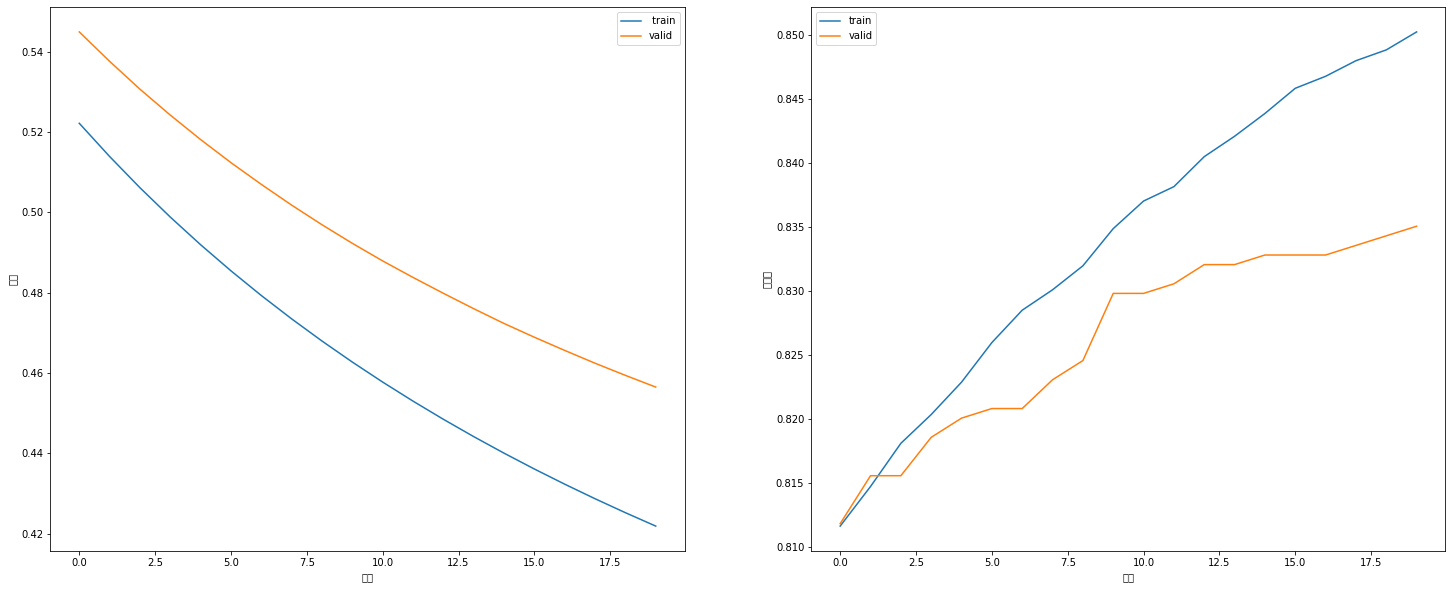

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

fig , ax = plt.subplots(1 , 2 , figsize=(25 , 10))
#loss_epoch
ax[0].plot(np.array(log_train).T[0] , label =' train')
ax[0].plot(np.array(log_valid).T[0] , label = 'valid')
ax[0].set_xlabel('回数')
ax[0].set_ylabel('損失')
ax[0].legend()
#acc_epoch
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('回数')
ax[1].set_ylabel('正答率')
ax[1].legend()
plt.show()

In [30]:
# 参考https://yoshinashigoto-blog.herokuapp.com/detail/30/
# https://exture-ri.com/2021/01/04/pytorch-nn/
# https://yoshinashigoto-blog.herokuapp.com/detail/27/
# https://qiita.com/noknmgc/items/3b8531266e8986ca63fe
# https://qiita.com/awawaInu/items/e173acded17a142e6d02

# チェックポイント
## 問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．


In [31]:
#時間がかかるので少なめに設定する
log_train = []
log_valid = []

for epoch in range(20):
    model.train()
    for inputs, labels in dataloader_train:
        op.zero_grad()#加算されてしまうのでリセット
        y_pred = model(inputs)#modelを用いて予測
        loss = CE(y_pred , labels)#誤差
        loss.backward()#誤差修正
        op.step()#更新

    # 正解率等の計算
    loss_train , acc_train = loss_acc(model , CE , dataloader_train)
    loss_valid , acc_valid = loss_acc(model , CE , dataloader_valid)
    log_train.append([loss_train , acc_train])
    log_valid.append([loss_valid , acc_valid])

    # チェックポイント new
    torch.save({'epoch' : epoch , 'model_state_dict' : model.state_dict() , 'optimizer_state_dict' : op.state_dict()} , f'checkpoint{epoch + 1}.pt')

    # ログを出力
    print(f'epoch : {epoch + 1} , loss_train : {loss_train} , accuracy_train : {acc_train} , loss_valid : {loss_valid} , accuracy_valid: {acc_valid}')  

epoch : 1 , loss_train : 0.41866474553504357 , accuracy_train : 0.8517616191904048 , loss_valid : 0.45367634296417236 , accuracy_valid: 0.8350824587706147
epoch : 2 , loss_train : 0.4155750499860446 , accuracy_train : 0.8528860569715142 , loss_valid : 0.45099127292633057 , accuracy_valid: 0.835832083958021
epoch : 3 , loss_train : 0.4125997568289546 , accuracy_train : 0.8540104947526237 , loss_valid : 0.4483470618724823 , accuracy_valid: 0.8365817091454273
epoch : 4 , loss_train : 0.40972968916759805 , accuracy_train : 0.8552286356821589 , loss_valid : 0.4458979666233063 , accuracy_valid: 0.8373313343328336
epoch : 5 , loss_train : 0.40696484812649275 , accuracy_train : 0.856071964017991 , loss_valid : 0.4434671103954315 , accuracy_valid: 0.8373313343328336
epoch : 6 , loss_train : 0.40428803750723846 , accuracy_train : 0.8569152923538231 , loss_valid : 0.4411099851131439 , accuracy_valid: 0.8380809595202399
epoch : 7 , loss_train : 0.4017047623098857 , accuracy_train : 0.8577586206896

# ミニバッチ化
## 問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [32]:
import time

def train_model(ds_train , ds_valid , batch_size , model , CE , op , epochs):
    # dataloaderの作成
    dataloader_train = DataLoader(ds_train , batch_size = batch_size , shuffle = True)
    dataloader_valid = DataLoader(ds_valid , batch_size = len(ds_valid) , shuffle = False)

    # 学習
    log_train = []
    log_valid = []
    for epoch in range(epochs):
        start = time.time()#計測開始
        model.train()

        for inputs, labels in dataloader_train:
            op.zero_grad()#加算されてしまうのでリセット
            y_pred = model(inputs)#modelを用いて予測
            loss = CE(y_pred , labels)#誤差
            loss.backward()#誤差修正
            op.step()#更新

        # 正解率等の計算
        loss_train , acc_train = loss_acc(model , CE , dataloader_train)
        loss_valid , acc_valid = loss_acc(model , CE , dataloader_valid)
        log_train.append([loss_train , acc_train])
        log_valid.append([loss_valid , acc_valid])

        # # チェックポイント new
        # torch.save({'epoch' : epoch , 'model_state_dict' : model.state_dict() , 'optimizer_state_dict' : op.state_dict()} , f'checkpoint{epoch + 1}.pt')

        end = time.time()#計測完了

        # ログを出力
        print(f'epoch : {epoch + 1} , loss_train : {loss_train} , accuracy_train : {acc_train} , loss_valid : {loss_valid} , accuracy_valid : {acc_valid} , {end - start} sec') 

    return {'train' : log_train , 'valid' : log_valid}

In [33]:
for batch_size in [2 ** i for i in range(5)]:
    print(f'バッチサイズ : {batch_size}')
    log = train_model(ds_train , ds_valid , batch_size , model , CE , op , 1)

バッチサイズ : 1
epoch : 1 , loss_train : 0.3728350896131372 , accuracy_train : 0.8686281859070465 , loss_valid : 0.41373005509376526 , accuracy_valid : 0.8523238380809596 , 4.215559005737305 sec
バッチサイズ : 2
epoch : 1 , loss_train : 0.37199931908319 , accuracy_train : 0.8687218890554723 , loss_valid : 0.4129936099052429 , accuracy_valid : 0.8515742128935532 , 2.3250138759613037 sec
バッチサイズ : 4
epoch : 1 , loss_train : 0.3715855209282973 , accuracy_train : 0.8687218890554723 , loss_valid : 0.4126338064670563 , accuracy_valid : 0.8515742128935532 , 1.186842679977417 sec
バッチサイズ : 8
epoch : 1 , loss_train : 0.37137952486592074 , accuracy_train : 0.868815592203898 , loss_valid : 0.4124557375907898 , accuracy_valid : 0.8523238380809596 , 0.67120361328125 sec
バッチサイズ : 16
epoch : 1 , loss_train : 0.3712767918818983 , accuracy_train : 0.868815592203898 , loss_valid : 0.4123665690422058 , accuracy_valid : 0.8523238380809596 , 0.4283716678619385 sec


In [34]:
# 参考https://gotutiyan.hatenablog.com/entry/2020/04/21/182937
# https://tzmi.hatenablog.com/entry/2020/04/11/234417
# https://qiita.com/kimisyo/items/9508aff5a25e70772d5c

# GPU上での学習
## 問題77のコードを改変し，GPU上で学習を実行せよ．

In [35]:
def loss_acc_gpu(model , criterion , loader , device):
    model.eval()
    loss = 0.0
    y_true = 0
    y_pred = 0

    with torch.no_grad():
        for inputs, labels in loader:

            inputs = inputs.to(device)#gpu
            labels = labels.to(device)#gpu

            outputs = model(inputs)
            loss += criterion(outputs , labels).item()#new
            pred = torch.argmax(outputs , dim=-1)
            y_true += len(inputs)
            y_pred += (pred == labels).sum().item()

    return loss / len(loader) , y_pred / y_true

In [36]:
def train_model(ds_train , ds_valid , batch_size , model , CE , op , epochs , device=None):
    model.to(device)#gpu
    # dataloaderの作成
    dataloader_train = DataLoader(ds_train , batch_size = batch_size , shuffle = True)
    dataloader_valid = DataLoader(ds_valid , batch_size = len(ds_valid) , shuffle = False)

    # 学習
    log_train = []
    log_valid = []
    for epoch in range(epochs):
        start = time.time()#計測開始
        model.train()

        for inputs, labels in dataloader_train:
            op.zero_grad()#加算されてしまうのでリセット

            inputs = inputs.to(device)#gpu
            labels = labels.to(device)#gpu

            y_pred = model(inputs)#modelを用いて予測
            loss = CE(y_pred , labels)#誤差
            loss.backward()#誤差修正
            op.step()#更新

        # 正解率等の計算
        loss_train , acc_train = loss_acc_gpu(model , CE , dataloader_train , device)#gpu
        loss_valid , acc_valid = loss_acc_gpu(model , CE , dataloader_valid , device)#gpu
        log_train.append([loss_train , acc_train])
        log_valid.append([loss_valid , acc_valid])

        # # チェックポイント new
        # torch.save({'epoch' : epoch , 'model_state_dict' : model.state_dict() , 'optimizer_state_dict' : op.state_dict()} , f'checkpoint{epoch + 1}.pt')

        end = time.time()#計測完了

        # ログを出力
        print(f'epoch : {epoch + 1} , loss_train : {loss_train} , accuracy_train : {acc_train} , loss_valid : {loss_valid} , accuracy_valid : {acc_valid} , {end - start} sec') 

    return {'train' : log_train , 'valid' : log_valid}

In [37]:
# device = torch.device('cuda') #gpu
device = torch.device('cpu')#制限があるのでcpu
print(device)

for batch_size in [2 ** i for i in range(4)]:
    print(f'バッチサイズ : {batch_size}')
    log = train_model(ds_train , ds_valid , batch_size , model , CE , op , 1 , device = device)

cpu
バッチサイズ : 1
epoch : 1 , loss_train : 0.3696565867994805 , accuracy_train : 0.8695652173913043 , loss_valid : 0.4109687805175781 , accuracy_valid : 0.8545727136431784 , 4.31265926361084 sec
バッチサイズ : 2
epoch : 1 , loss_train : 0.36886151249662313 , accuracy_train : 0.8699400299850075 , loss_valid : 0.41028454899787903 , accuracy_valid : 0.8545727136431784 , 2.3361501693725586 sec
バッチサイズ : 4
epoch : 1 , loss_train : 0.3684672575753435 , accuracy_train : 0.8701274362818591 , loss_valid : 0.4099405109882355 , accuracy_valid : 0.8545727136431784 , 1.2421343326568604 sec
バッチサイズ : 8
epoch : 1 , loss_train : 0.36827109253586926 , accuracy_train : 0.8701274362818591 , loss_valid : 0.4097695052623749 , accuracy_valid : 0.8545727136431784 , 0.6844940185546875 sec


In [38]:
# 参考https://note.nkmk.me/python-pytorch-cuda-is-available-device-count/
# https://atmarkit.itmedia.co.jp/ait/articles/2008/28/news030.html

# 多層ニューラルネットワーク
## 問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [39]:
# class model_ln_layers(nn.Module):
#     def __init__(self , input_size , hidden_size , output_size , num_layers):
#         super().__init__()
#         self.num_layers = num_layers
#         self.fc = nn.Linear(input_size , hidden_size)
#         self.fc_mid = nn.Linear(hidden_size , hidden_size)
#         self.fc_out = nn.Linear(hidden_size , output_size)
#         self.bn = nn.BatchNorm1d(hidden_size)

#     def forward(self, x):
#         x = F.relu(self.fc(x))
#         for _ in range(self.num_layers):
#             x = F.relu(self.bn(self.fc_mid(x)))
#         x = F.relu(self.fc_out(x))

#         return x

In [40]:
# #時間がかかるので少なめに設定する
# model = model_ln_layers(300 , 200 , 4 , 5)

# log = train_model(ds_train , ds_valid , 64 , model , CE , op , 20 , device)

In [41]:
class model_ln_layers(nn.Module):
    def __init__(self , input_size , hidden_size , output_size):
        super().__init__()
        self.fc = nn.Linear(input_size , hidden_size)
        self.fc_mid_1 = nn.Linear(hidden_size , hidden_size)
        self.fc_mid_2 = nn.Linear(hidden_size , hidden_size)
        self.fc_mid_3 = nn.Linear(hidden_size , hidden_size)
        self.fc_out = nn.Linear(hidden_size , output_size)
        self.bn = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = F.relu(self.bn(self.fc_mid_1(x)))
        x = F.relu(self.bn(self.fc_mid_2(x)))
        x = F.relu(self.bn(self.fc_mid_3(x)))
        x = F.relu(self.fc_out(x))

        return x

In [42]:
model = model_ln_layers(300 , 200 , 4)

log = train_model(ds_train , ds_valid , 64 , model , CE , op , 20 , device)

epoch : 1 , loss_train : 1.37579283956996 , accuracy_train : 0.4196026986506747 , loss_valid : 1.3754905462265015 , accuracy_valid : 0.42128935532233885 , 0.6841373443603516 sec
epoch : 2 , loss_train : 1.366319688494334 , accuracy_train : 0.42175787106446777 , loss_valid : 1.3656294345855713 , accuracy_valid : 0.42128935532233885 , 0.7012794017791748 sec
epoch : 3 , loss_train : 1.379738363677156 , accuracy_train : 0.4165104947526237 , loss_valid : 1.3791431188583374 , accuracy_valid : 0.4197901049475262 , 0.6909158229827881 sec
epoch : 4 , loss_train : 1.3673580185381953 , accuracy_train : 0.42175787106446777 , loss_valid : 1.366934895515442 , accuracy_valid : 0.42128935532233885 , 0.6760396957397461 sec
epoch : 5 , loss_train : 1.370268042216044 , accuracy_train : 0.42185157421289354 , loss_valid : 1.3698453903198242 , accuracy_valid : 0.42128935532233885 , 0.6785793304443359 sec
epoch : 6 , loss_train : 1.3677580328044776 , accuracy_train : 0.42175787106446777 , loss_valid : 1.3671

In [43]:
# class Net(nn.Module):
#     def __init__(self , input_size , hidden_size , output_size):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size , hidden_size)
#         self.fc4 = nn.Linear(hidden_size , hidden_size)
#         self.fc5 = nn.Linear(hidden_size , hidden_size)
#         self.fc6 = nn.Linear(hidden_size , output_size)

         
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))
#         x = self.fc6(x)
#         return F.log_softmax(x , dim=0)

In [44]:
# input_size = 300
# output_size = 4
# hidden_size = 50
# num_epochs = 3#testのため回数少なめ
# learning_rate = 1e-3
# batch_size = 50

# CE = nn.CrossEntropyLoss()
# op = optim.SGD(model.parameters() , lr = learning_rate)

# model = Net(input_size , hidden_size , output_size)
# log = train_model(ds_train , ds_valid , 64 , model , CE , op , 20 , device)

In [45]:
# 参考https://qiita.com/sudamasahiko/items/b54fed1ffe8bb6d48818
# https://atmarkit.itmedia.co.jp/ait/articles/2002/06/news025.html
# https://recruit.gmo.jp/engineer/jisedai/blog/pytorch_simplenn_to_gan/
# https://wonderfuru.com/scheduler/
# https://katsura-jp.hatenablog.com/entry/2019/01/30/183501